In [2]:
import os
import shutil

In [3]:
os.environ['KAGGLE_CONFIG_DIR']="/content"

In [4]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:44<00:00, 49.6MB/s]
100% 2.29G/2.29G [00:44<00:00, 55.2MB/s]


In [5]:
shutil.copy2('/content/drive/My Drive/Untitled folder/Dataset.zip','.')
shutil.copy2('/content/drive/My Drive/Untitled folder/b2.zip','.')

'./b2.zip'

In [6]:
from zipfile import ZipFile
fname='/content/Dataset.zip'
with ZipFile(fname,'r') as zip:
  zip.extractall()
  print('done')

fname='/content/chest-xray-pneumonia.zip'
with ZipFile(fname,'r') as zip:
  zip.extractall()
  print('done')

fname='/content/b2.zip'
with ZipFile(fname,'r') as zip:
  zip.extractall()
  print('done')

done
done
done


In [7]:
os.mkdir('dataset')
shutil.move('/content/covid','dataset')
shutil.move('/content/chest_xray/train/NORMAL','dataset')
shutil.move('/content/b2/becteria','dataset')

'dataset/becteria'

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input,Lambda,Dense,Flatten,AveragePooling2D,Dropout
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.applications import VGG16

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix,roc_curve
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

In [2]:
IMAGE_SIZE=[224,224]

epochs=50
batch_size=32

covid_path='/content/dataset/covid'
normal_path='/content/dataset/NORMAL'
pneumonia_path='/content/dataset/PNEUMONIA'

covid_files=glob(covid_path+'/*')
normal_files=glob(normal_path+'/*')
pneumonia_files=glob(normal_path+'/*')

In [3]:
covid_labels=[]
normal_labels=[]
pneumonia_labels=[]

covid_images=[]
normal_images=[]
pneumonia_images=[]

import cv2
for i in range(len(covid_files)):
  image=cv2.imread(covid_files[i])
  image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
  image=cv2.resize(image,(224,224))
  covid_images.append(image)
  covid_labels.append('covid')

for i in range(700):
  image=cv2.imread(normal_files[i])
  image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
  image=cv2.resize(image,(224,224))
  normal_images.append(image)
  normal_labels.append('normal')

for i in range(700):
  image=cv2.imread(pneumonia_files[i])
  image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
  image=cv2.resize(image,(224,224))
  pneumonia_images.append(image)
  pneumonia_labels.append('pneumonia')

In [4]:
covid_images=np.array(covid_images)/255.0
normal_images=np.array(normal_images)/255.0
pneumonia_images=np.array(pneumonia_images)/255.0

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

#split to train,test
covid_x_train,covid_x_test,covid_y_train,covid_y_test=train_test_split(covid_images,covid_labels,test_size=.2)
normal_x_train,normal_x_test,normal_y_train,normal_y_test=train_test_split(normal_images,normal_labels,test_size=.2)
pneumonia_x_train,pneumonia_x_test,pneumonia_y_train,pneumonia_y_test=train_test_split(pneumonia_images,pneumonia_labels,test_size=.2)

X_train=np.concatenate((pneumonia_x_train,normal_x_train,covid_x_train),axis=0)
X_test=np.concatenate((pneumonia_x_test,normal_x_test,covid_x_test),axis=0)
Y_train=np.concatenate((pneumonia_y_train,normal_y_train,covid_y_train),axis=0)
Y_test=np.concatenate((pneumonia_y_test,normal_y_test,covid_y_test),axis=0)

In [6]:
Y_train=LabelBinarizer().fit_transform(Y_train)
Y_test=LabelBinarizer().fit_transform(Y_test)

In [23]:
vgg16=VGG16(weights='imagenet',include_top=False,input_tensor=Input(shape=(224,224,3)))

outputs=vgg16.output
outputs=AveragePooling2D(pool_size=(4,4))(outputs)
outputs=Dropout(.5)(outputs)
outputs=Flatten(name='flattern')(outputs)
outputs=Dropout(.5)(outputs)
# outputs=Dense(32,activation='relu')(outputs)
# outputs=Dropout(.5)(outputs)
outputs=Dense(3,activation='softmax')(outputs)

model=Model(inputs=vgg16.input,outputs=outputs)

for layer in vgg16.layers:
  layer.trainable=False

INIT_LR = 0.001
EPOCHS = 40
BATCHSIZE = 32 
optimizer=tf.keras.optimizers.Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.AUC()]
)

train_aug=ImageDataGenerator(
    rotation_range=20,
    width_shift_range=.2,
    height_shift_range=.2,
    horizontal_flip=True
)

In [24]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')

In [25]:
history=model.fit(train_aug.flow(X_train,Y_train,batch_size=32),
                  validation_data=(X_test,Y_test),
                  validation_steps=len(X_test)/32,
                  steps_per_epoch=len(X_train)/32,
                  callbacks=[checkpoint],
                  epochs=EPOCHS
)

Epoch 1/40
47/46 [==============================] - ETA: 0s - loss: 1.3085 - categorical_accuracy: 0.3794 - auc_4: 0.5584
Epoch 00001: val_loss improved from inf to 1.00194, saving model to model.h5
47/46 [==============================] - 18s 374ms/step - loss: 1.3085 - categorical_accuracy: 0.3794 - auc_4: 0.5584 - val_loss: 1.0019 - val_categorical_accuracy: 0.3703 - val_auc_4: 0.6612
Epoch 2/40
47/46 [==============================] - ETA: 0s - loss: 1.1272 - categorical_accuracy: 0.4309 - auc_4: 0.6019
Epoch 00002: val_loss improved from 1.00194 to 0.95370, saving model to model.h5
47/46 [==============================] - 17s 360ms/step - loss: 1.1272 - categorical_accuracy: 0.4309 - auc_4: 0.6019 - val_loss: 0.9537 - val_categorical_accuracy: 0.4811 - val_auc_4: 0.7171
Epoch 3/40
47/46 [==============================] - ETA: 0s - loss: 1.0324 - categorical_accuracy: 0.4505 - auc_4: 0.6525
Epoch 00003: val_loss improved from 0.95370 to 0.92148, saving model to model.h5
47/46 [====

In [26]:
# del model
del covid_x_train,covid_x_test,covid_y_train,covid_y_test
del normal_x_train,normal_x_test,normal_y_train,normal_y_test
del pneumonia_x_train,pneumonia_x_test,pneumonia_y_train,pneumonia_y_test

NameError: ignored

In [27]:
# model=load_model('model.h5')
y_pred=model.predict(X_test,batch_size=32)

In [28]:
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(Y_test, axis=1)

Confusion Matrix without Normalization


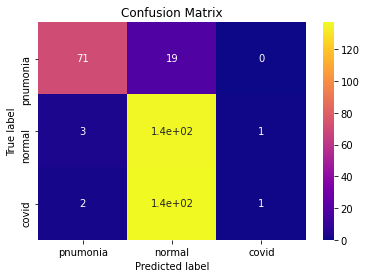

Confusion Matrix with Normalized Values


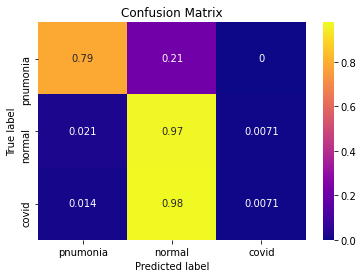

In [29]:
import seaborn as sns
def plot_confusion_matrix(normalize):
  classes = ['pnumonia','normal','covid']
  tick_marks = [0.5,1.5,2.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')